In [11]:
!pip install pytorchvideo

from IPython import display
display.clear_output()

In [1]:
#-- Import Libraries -------------------------------------------------------------------------------------
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import math
from PIL import Image
#---------------------------------------------------------------------------------------------------------

In [3]:
#--Initialize ---------------------------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

NUM_CLASSES = 2
CLASS_NAMES = ['fight', 'normal']

NUM_FRAMES = 32
FRAME_W = 256
FRAME_H = 256
#---------------------------------------------------------------------------------------------------------

device: cpu


In [4]:
#-- X3D Model  --------------------------------------------------------------------------------------------
def custome_X3D(num_classes):
    #-- load X3D model --
    model_name = 'x3d_m'
    model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)   
    
     #-- Freeze all layers --
    for param in model.parameters():
        param.requires_grad = False
    
    #-- set last layer for custome classification --
    input_size = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(in_features=input_size, out_features=num_classes)
    
    #-- Unfreeze 5 Last Block --
    for param in model.blocks[5].parameters():
        param.requires_grad = True
    for param in model.blocks[4].parameters():
        param.requires_grad = True
    for param in model.blocks[3].parameters():
        param.requires_grad = True
    for param in model.blocks[2].parameters():
        param.requires_grad = True
    for param in model.blocks[1].parameters():
        param.requires_grad = True

    return model
#-----------------------------------------------------------------------------------------------------------------

In [5]:
#-- Function to Preprocess videos -------------------------------------------------------------------------------
def preprocess_video(video_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):    
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, resize)
        frames.append(frame)
    cap.release()

    frames = np.array(frames)

    #-- Sample frames --
    if len(frames) > num_frames:
        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        sampled_frames = frames[indices]
    elif len(frames) < num_frames:
        padding = np.zeros((num_frames - len(frames), *resize, 3))
        sampled_frames = np.concatenate((frames, padding), axis=0)
    else:
        sampled_frames = frames
    
    sampled_frames 
    
    
    #-- Convert to tensor and add batch dimension --
    sampled_frames = np.transpose(sampled_frames, (3, 0, 1, 2))  #[frames, channels, height, width]
    sampled_frames = torch.from_numpy(sampled_frames).float().unsqueeze(0)  # add batch dimension
    
    sampled_frames  = sampled_frames / 255.0
    
    return sampled_frames
#-------------------------------------------------------------------------------------------------------------

In [15]:
#-- function to Predict video label ------------------------------------------------------------------------------
def predict_video(video_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    
    preprocessed_video = preprocess_video(video_path,
                                          NUM_FRAMES,
                                          (FRAME_W, FRAME_H))   
    
    #-- Predict label --
    with torch.no_grad():
        outputs = model(preprocessed_video)
        _, predicted = torch.max(outputs, 1)  
    
    return predicted.item()
#-------------------------------------------------------------------------------------------------------------

In [16]:
#-- Hook function to get the features from the desired layer --------------------------------------------------
def save_features_hook(module, input, output):
    global features
    features = output
#-------------------------------------------------------------------------------------------------------------

In [17]:
#-- Hook function to get the gradients of the output with respect to the chosen layer -----------------------
def save_grads_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0]
#-------------------------------------------------------------------------------------------------------------

In [18]:
#-- Apply Grad-CAM ------------------------------------------------------------------------------------------
def apply_gradcam(model, video_tensor, target_layer):
    global features, grads

    #-- Register hooks--
    target_layer.register_forward_hook(save_features_hook)
    target_layer.register_backward_hook(save_grads_hook)

    #-- Forward pass --
    output = model(video_tensor)
    
    #-- Backward pass (with the target class) --
    target_class = torch.argmax(output, dim=1)
    model.zero_grad()
    output[0, target_class].backward()

    #-- Calculate the Grad-CAM --
    grads = grads.detach()  #-- Detach to avoid any further computation
    features = features.detach()

    #-- Global average pooling --
    weights = torch.mean(grads, dim=(2, 3), keepdim=True)  #-- Global average over spatial dimensions (height, width)
    
    #-- Weighted sum of feature maps --
    cam = torch.sum(weights * features, dim=1, keepdim=True)

    #-- ReLU activation --
    cam = F.relu(cam)

    #-- Normalize the CAM --
    cam = cam - torch.min(cam)
    cam = cam / torch.max(cam)

    return cam.squeeze().cpu().numpy()
#-------------------------------------------------------------------------------------------------------------

In [19]:
#-- Function to Visualize GradCAM on Frames ------------------------------------------------------------------
def visualize_gradcam_per_frame(video_tensor, gradcam_output, resize=(256, 256)):
    
    heatmap_images = []

    #-- Ensure the Grad-CAM output is resized to match the frame size --
    gradcam_output_resized = np.zeros((gradcam_output.shape[0], resize[0], resize[1], 3))  

    #-- Resize Grad-CAM for each frame to match the frame dimensions --
    for i in range(gradcam_output.shape[0]):        
        gradcam_map = cv2.resize(gradcam_output[i], (resize[1], resize[0]))  
        gradcam_map = np.uint8(255 * gradcam_map)  
        gradcam_map = cv2.cvtColor(gradcam_map, cv2.COLOR_GRAY2BGR)  #-- Convert to 3-channel image
        gradcam_output_resized[i] = gradcam_map

    #-- Remove batch dimension and process each frame --    
    video_tensor = video_tensor.squeeze(0).cpu().numpy()      
    video_tensor =  np.transpose(video_tensor, (1, 2, 3, 0))     
    
    for frame_idx in range(video_tensor.shape[0]):          
        frame = video_tensor[frame_idx]
        frame = np.uint8(255 * frame)         
        
        frame_resized = cv2.resize(frame, (resize[1], resize[0]))        
        
        current_gradcam_output_resized = gradcam_output_resized[frame_idx]        
       
        current_gradcam_output_resized = np.uint8(current_gradcam_output_resized)
        
        heatmap = cv2.applyColorMap(current_gradcam_output_resized, cv2.COLORMAP_JET)
        
        #-- Combine heatmap and resized frame --        
        combined = cv2.addWeighted(frame_resized, 0.6, heatmap, 0.4, 0)       
       
        heatmap_images.append(combined)
    
    return heatmap_images
#-------------------------------------------------------------------------------------------------------------

In [25]:
#-- Function to predict with Grad-CAM visualization for each frame ------------------------------------------
def predict_with_gradcam_per_frame(model, video_path, target_layer, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    
    preprocessed_video = preprocess_video(video_path, num_frames, resize)      
    gradcam_output = apply_gradcam(model, preprocessed_video, target_layer)      
    attention_scores = gradcam_output.mean(axis=(1, 2))  
    
    
    plt.figure(figsize=(12, 5))
    plt.plot(attention_scores, marker='o', color='crimson')
    plt.title('Grad-CAM Attention per Frame')
    plt.xlabel('Frame Index')
    plt.ylabel('Mean Grad-CAM Activation')
    plt.grid(True)
    plt.show()

    show_top_gradcam_frames(preprocessed_video, gradcam_output,6)
    
    gradcam_images = visualize_gradcam_per_frame(preprocessed_video, gradcam_output)
    with torch.no_grad():
        outputs = model(preprocessed_video)
        _, predicted = torch.max(outputs, 1)

    return predicted.item(), gradcam_images
#-------------------------------------------------------------------------------------------------------------

In [21]:
#-------------------------------------------------------------------------------------------------------------
def show_top_gradcam_frames(video_tensor, gradcam_output, top_k=5, max_cols=3):
    # Step 1: Compute average activation per frame
    attention_scores = gradcam_output.mean(axis=(1, 2)) 

    # Step 2: Get top-k indices
    top_indices = np.argsort(attention_scores)[-top_k:][::-1]  

    # Step 3: Prepare for visualization
    video_np = video_tensor.squeeze().permute(1, 2, 3, 0).cpu().numpy()  

    # Step 4: Plotting setup
    cols = min(top_k, max_cols)
    rows = math.ceil(top_k / cols)

    plt.figure(figsize=(3 * cols, 3 * rows))
    for i, idx in enumerate(top_indices):
        frame = video_np[idx]
        heatmap = gradcam_output[idx]
        heatmap_resized = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized / (heatmap_resized.max() + 1e-6))
        heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        frame_uint8 = np.uint8(255 * frame)
        frame_bgr = cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR)
        overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color, 0.4, 0)
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(overlay_rgb)
        plt.title(f"Frame {idx}\nScore: {attention_scores[idx]:.3f}")
        plt.axis('off')

    plt.suptitle("Top Attention Frames by Grad-CAM", fontsize=16)
    plt.tight_layout()
    plt.show()
#-------------------------------------------------------------------------------------------------------------

In [22]:
#-- Create X3d Model ----------------------------------------------------------------------------------------
best_weights_dir = "/kaggle/input/fight-detection-x3d-32-v2-3-fold3/3_best.pth"

#-- Create the model architecture --
model = custome_X3D(NUM_CLASSES)

#-- Load the saved state dictionary --
model.load_state_dict(torch.load(best_weights_dir, map_location=torch.device(DEVICE)))
model.eval()

print('Model Loaded :)')
#-------------------------------------------------------------------------------------------------------------

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
<ipython-input-22-ca98cd60b7c6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_st

Model Loaded :)


In [23]:
#-- Choose a layer for Grad-CAM --
target_layer = model.blocks[4]  

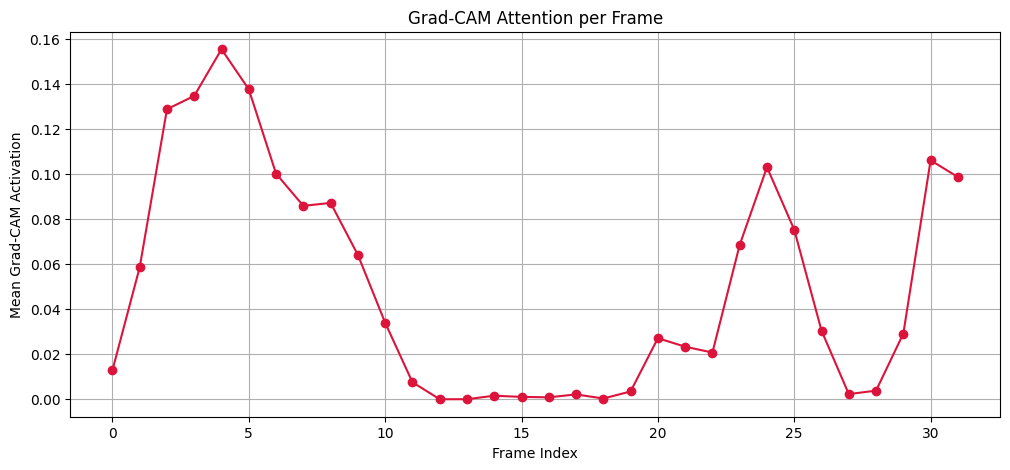

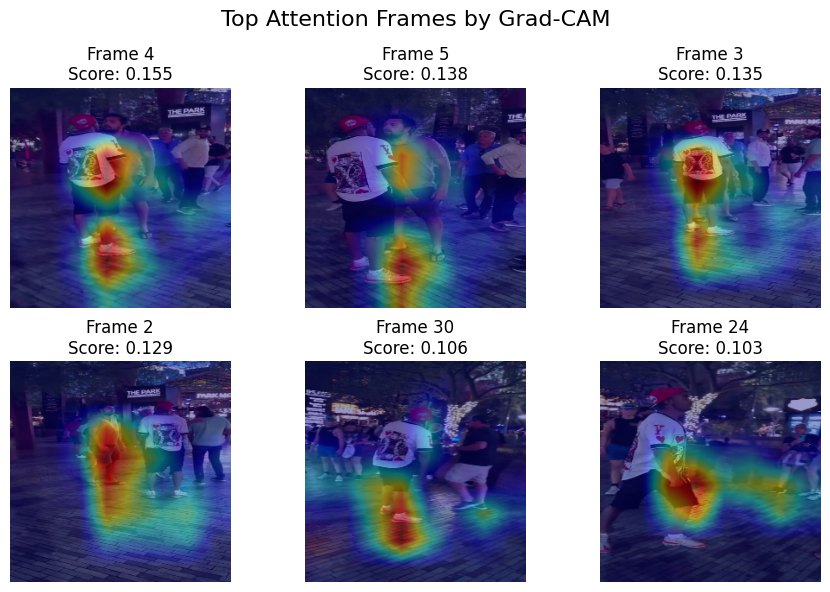

predicted_label: fight


In [28]:
#-- Run ------------------------------------------------------------------------------------------------
video_path = '/kaggle/input/sample-videos-for-fight-detection-2/fight/fight (3).mp4'
# video_path = '/kaggle/input/sample-videos-for-fight-detection-2/normal/normal (2).mp4'

predicted_label, gradcam_images = predict_with_gradcam_per_frame(model, video_path, target_layer)
print('predicted_label:' , CLASS_NAMES[predicted_label])
#-------------------------------------------------------------------------------------------------------------
